# Network Analysis

Created: 14/05/2024

Last updated: 08/05/2024

Created by: Alisea Stroligo

In [2]:
"""
WARNING: 

This script is part of the pre-processing part of the analysis, it performs analyses on the original dataset therefore it is computation heavy
(original dataset ~3GB). The aim of this analysis is to find features that difference subreddits and guide the decision on the subreddit to choose
for further analyses.

"""

'\nWARNING: \n\nThis script is part of the pre-processing part of the analysis, it performs analyses on the original dataset therefore it is computation heavy\n(original dataset ~3GB). The aim of this analysis is to find features that difference subreddits and guide the decision on the subreddit to choose\nfor further analyses.\n\n'

In [3]:
#SETUP

#uncomment only on first run of script
"""
from datasets import load_dataset, load_metric 
import os 
"""

import pandas as pd
import numpy as np
import seaborn as sns
import csv
import matplotlib.pyplot as plt
import itertools
import networkx as nx
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')


In [4]:
"""
#DOWLOADING DATASET (ONLY USE ON FIRST RUN OF THE SCRIPT)

webis_tldr = load_dataset('reddit', split='train') #split='train' downloads the whole dataset
df = webis_tldr.to_pandas()
df.head()

#saving dataset to csv file
if not os.path.exists("data"):
    os.makedirs("data")

# Save data to the "data" folder and use quoting to avoid corrupting the data
df.to_csv("data/webis_tldr.csv", index=False, sep=";", encoding='utf-8', quoting=csv.QUOTE_NONNUMERIC)


#IMPORTING DATASET

original_df = pd.read_csv("../data/webis_tldr.csv",  sep = ';')
original_df.head()

# DATA CLEANING
df_filtered = original_df.copy()
df_filtered = df_filtered.sample(10000) #selecting a random sample from the complete dataset for visualization purposes

#filtering empty or nan or uninformative content
df_filtered  = df_filtered.dropna()
df_filtered = df_filtered[df_filtered['author'] != '[deleted]']

#filtering out duplicates (same content by same user in same subreddit)
df_filtered.drop_duplicates(subset=['author', 'content','subreddit'], keep=False, inplace=True)

#saving new cleaned dataframe
df_filtered.to_csv("../data/webis_tldr_clean.csv", index=False, sep=";", encoding='utf-8', quoting=csv.QUOTE_NONNUMERIC)

"""

'\n#DOWLOADING DATASET (ONLY USE ON FIRST RUN OF THE SCRIPT)\n\nwebis_tldr = load_dataset(\'reddit\', split=\'train\') #split=\'train\' downloads the whole dataset\ndf = webis_tldr.to_pandas()\ndf.head()\n\n#saving dataset to csv file\nif not os.path.exists("data"):\n    os.makedirs("data")\n\n# Save data to the "data" folder and use quoting to avoid corrupting the data\ndf.to_csv("data/webis_tldr.csv", index=False, sep=";", encoding=\'utf-8\', quoting=csv.QUOTE_NONNUMERIC)\n\n\n#IMPORTING DATASET\n\noriginal_df = pd.read_csv("../data/webis_tldr.csv",  sep = \';\')\noriginal_df.head()\n\n# DATA CLEANING\ndf_filtered = original_df.copy()\ndf_filtered = df_filtered.sample(10000) #selecting a random sample from the complete dataset for visualization purposes\n\n#filtering empty or nan or uninformative content\ndf_filtered  = df_filtered.dropna()\ndf_filtered = df_filtered[df_filtered[\'author\'] != \'[deleted]\']\n\n#filtering out duplicates (same content by same user in same subreddit)\n

In [5]:

# LOADING FILTERED DATASET SAMPLE
df_filtered= pd.read_csv("data/webis_tldr_clean.csv",  sep = ';')
df_filtered.head()


,author,body,normalizedBody,subreddit,subreddit_id,id,content,summary
0,Octavian-,[Here are complete DPS and healing calculation...,[Here are complete DPS and healing calculation...,Guildwars2,t5_2r9po,t3_45thfj,Here are complete DPS and healing calculations...,Berserker's is probably outclassed by Condi if...
1,Reubarbarian,This question becomes heavily diluted when it ...,This question becomes heavily diluted when it ...,atheism,t5_2qh2p,cctplf3,This question becomes heavily diluted when it ...,If your (non-linguistic) arguement only has le...
2,DaveLLD,Driving to condisions....which means slowing d...,Driving to condisions....which means slowing d...,pics,t5_2qh0u,cf1synm,Driving to condisions....which means slowing d...,Winter is coming or something...
3,AO1793,"Hi r/teenagers, Some of you may remember me ...","Hi r/teenagers, Some of you may remember me ...",teenagers,t5_2rjli,t3_1qdjwt,"Hi r/teenagers, Some of you may remember me ...",You are gonna fuck up. Its ok. Thats life.
4,sp0ck06,"So had I, got it for christmas, started playin...","So had I, got it for christmas, started playin...",AskReddit,t5_2qh1i,c7otltn,"So had I, got it for christmas, started playin...","If you can get it cheap, or rent it, its worth..."


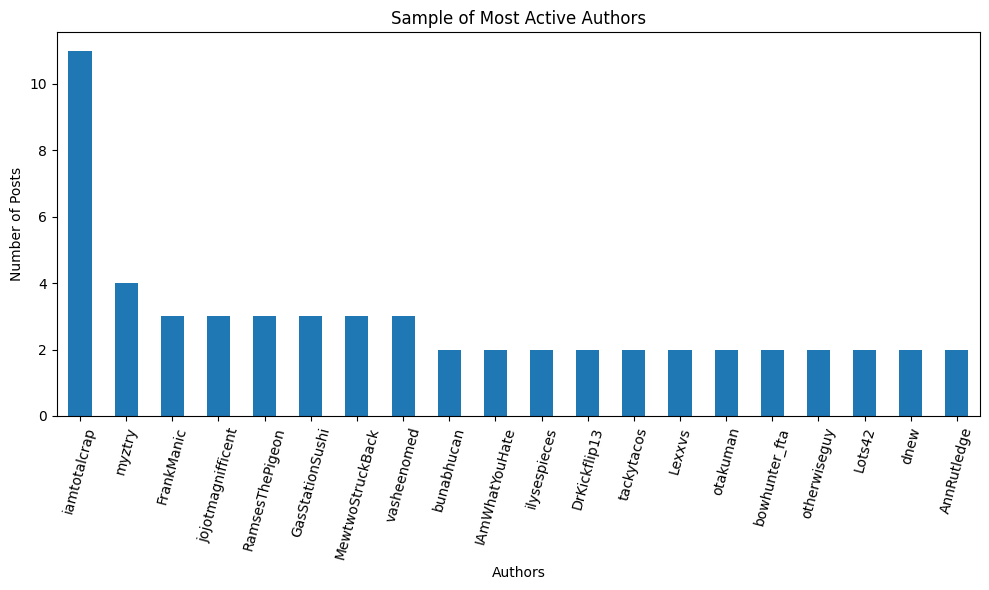

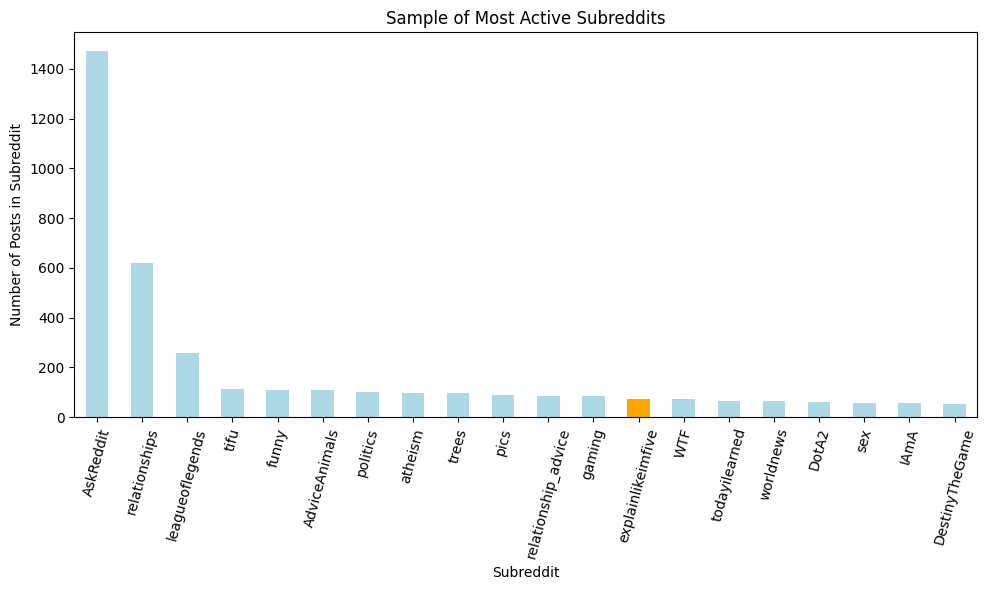

In [6]:
#GENERAL ANALYSES: understanding reddit posts' distribution before network plotting

# Count the frequency of each author
author_counts = df_filtered['author'].value_counts()[:20]

# Plot histogram for authors
plt.figure(figsize=(10, 6))
author_counts.plot(kind='bar')
plt.title('Sample of Most Active Authors')
plt.xlabel('Authors')
plt.ylabel('Number of Posts')
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

# Count the frequency of each topic
topic_counts = df_filtered['subreddit'].value_counts()[:20]
colors = ['lightblue']*len(topic_counts)
topic_countsdf = pd.DataFrame({'subreddit':topic_counts.index, 'count':topic_counts.values})
colors[topic_countsdf.subreddit[topic_countsdf.subreddit == 'explainlikeimfive'].index[0]] = 'orange'

# Plot histogram for topics
plt.figure(figsize=(10, 6))
topic_counts.plot(kind='bar', color=colors)
plt.title('Sample of Most Active Subreddits')
plt.xlabel('Subreddit')
plt.ylabel('Number of Posts in Subreddit')
plt.xticks(rotation=75)
plt.tight_layout()
plt.savefig('../figures/SampleSubreddit_ActivityDistribution_AllData.jpg') #saving figure
plt.show()


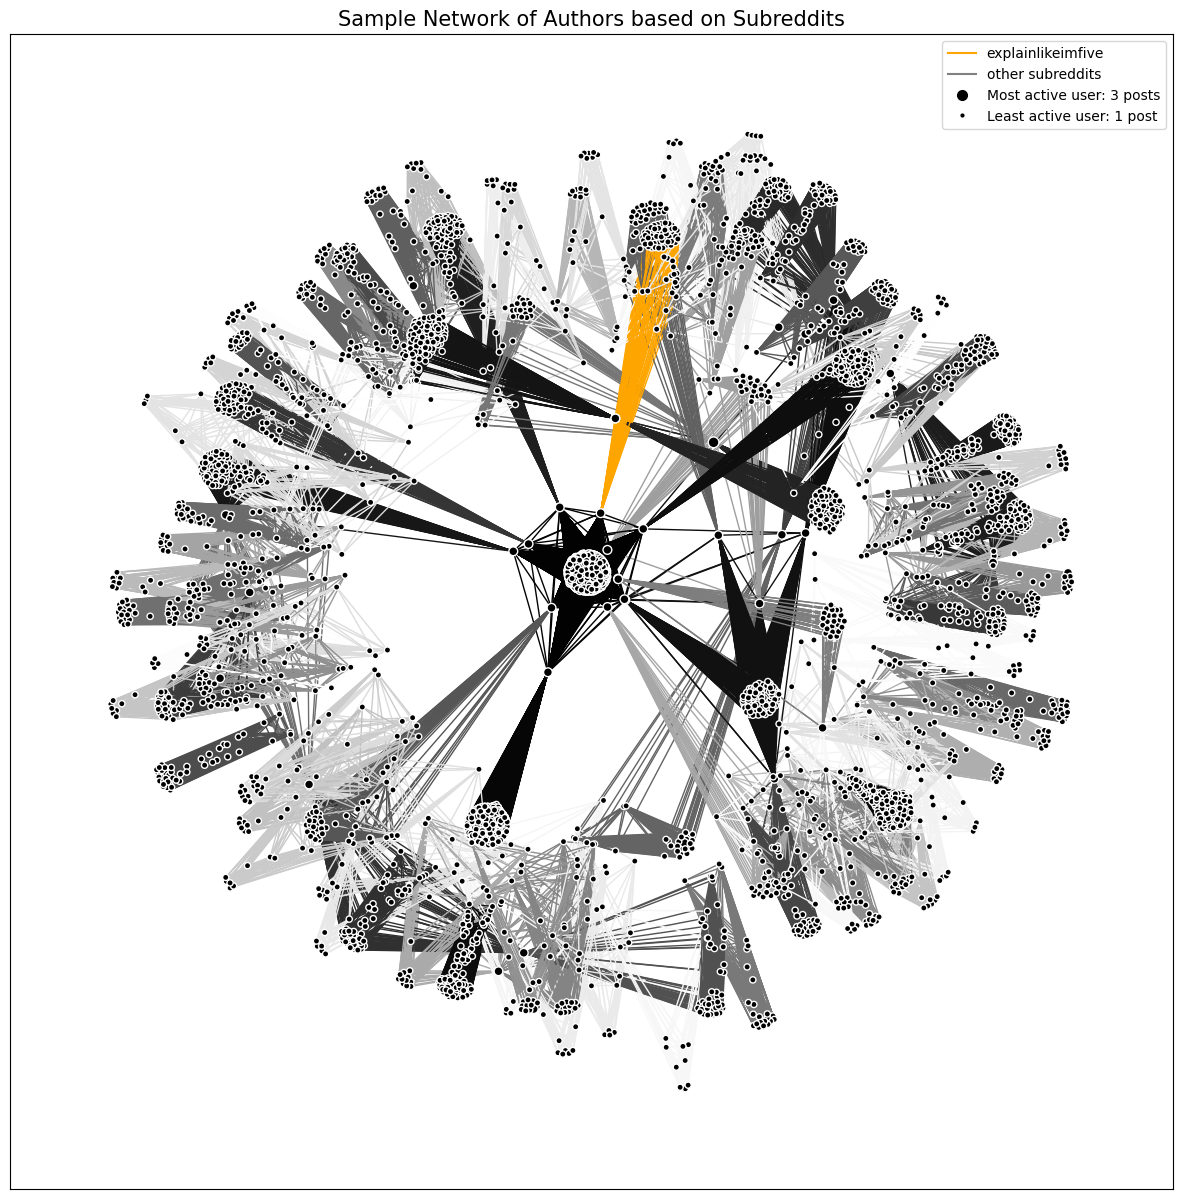

In [7]:
#NETWORK OF USERS based on subreddits (ALL SUBREDDITS)

author_graph = nx.Graph() #creating graph

# NETWORK OF USER CLUSTERS DEPENDING ON TOPIC

#Version 1: VADER
plt.figure(1,figsize=(15,15)) 

# selecting subreddit topics
top_subreddits = df_filtered['subreddit'].value_counts()
top_subreddits = pd.DataFrame({'subreddit':top_subreddits.index,'count':top_subreddits.values})
subreddit_list  = top_subreddits['subreddit'].unique()[0:100]
reduced_df = df_filtered[df_filtered['subreddit'].isin(subreddit_list)]

# Adding nodes
# node size determined by the number of occurrences (i.e. posts) of the author
author_counts = reduced_df['author'].value_counts().to_dict()
authors = reduced_df['author'].unique()
# creating nodes
for idx, author in enumerate(authors):
    if author_counts[author]!=0:
        author_graph.add_node(author, size=author_counts[author])

# Adding edges with subreddit as an attribute
subreddit_colors = sns.color_palette("Greys_r", len(subreddit_list))
for idx,subreddit in enumerate(subreddit_list):
    curr_subreddit_color = subreddit_colors[idx] 
    if subreddit=='explainlikeimfive':
        curr_subreddit_color = 'orange'
    authors_in_topic = reduced_df[reduced_df['subreddit'] == subreddit]['author'].unique()
    for i, author1 in enumerate(authors_in_topic):
        temp_authors2 = np.delete(authors_in_topic, i)
        for idx2 in range(len(temp_authors2)):
            author2 = temp_authors2[idx2]
            author_graph.add_edge(author1, author2, weight=0.001,color=curr_subreddit_color,width=0.01)

# node position
pos = nx.spring_layout(author_graph)
#pos = nx.kamada_kawai_layout(author_graph)

# drawing nodes
sizes = [author_graph.nodes[node]['size'] * 20 for node in author_graph.nodes] 
nx.draw_networkx_nodes(author_graph, pos, node_size=sizes, node_color='black',edgecolors='white')

# drawing edges
edges = author_graph.edges()
edge_colors = [author_graph[u][v]['color'] for u,v in edges]
nx.draw_networkx_edges(author_graph, pos, edge_color=edge_colors)

#creating legend: plot invisible lines for legend
top_authors = reduced_df['author'].value_counts()
plt.plot([], [], color='orange', markersize=10, label='explainlikeimfive', linestyle='solid')
plt.plot([], [], color='grey', markersize=10, label='other subreddits', linestyle='solid')
plt.plot([], [], color='none', marker='o', markersize=7, 
                          markerfacecolor='black', label=f'Most active user: {top_authors[0]} posts')
plt.plot([], [], color='none', marker='o', markersize=2, 
                          markerfacecolor='black', label=f'Least active user: 1 post')
plt.legend(loc='best')

plt.title('Sample Network of Authors based on Subreddits',fontsize=15)
plt.savefig('../figures/SampleAuthorNetworkGraph_AllData.jpg') #saving figure
plt.show()